# 2D Cellpose segmentation + Area/Aspect Ratio/Orientation Plots

##### Calculate mask parameters such as area, aspect ratio, distance from tailbud, orientation in reference to mediolateral axis etc. from 2D tiff images. 
##### Input are raw tiff file (e.g. raw.tiff), 8-bit tiff file where ROI is a binary filled area (e.g.raw-ROI.tiff), 8-bit tiff file where LOI is a binary line (e.g.raw-LOI.tiff) - [usually tailbud to the left]
##### Run in cp-nap-anal kernel

### Run Segmentation

In [191]:
# check GPU
from cellpose import core, utils, io, models, metrics, plot, denoise
use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')


>>> GPU activated? YES


In [192]:
# run nuclear model
dir = "//sv-nas1.rcp.epfl.ch/upoates/common/Feyza/Arianne-copied\midPSM-snaps"

# model parameters
model_path = "H:/PROJECTS-03/Agnese/cellpose training/2d/models/nuclei_h2b"
model = models.CellposeModel(gpu=True, pretrained_model=model_path)
channels = [[0,0]] # for single-channel image
cellprob_threshold = -1 # 0 when default

# gets image files in dir (ignoring image files ending in _masks)
files = io.get_image_files(dir, '_masks')
images = [io.imread(f) for f in files]

# run denoising    
dn = denoise.DenoiseModel (model_type='denoise_cyto3', gpu=True)
images = dn.eval(images, channels=channels)

# run model on images
masks, flows, styles = model.eval(images, diameter=None, channels=channels, cellprob_threshold=cellprob_threshold)

#save output masks to tiffs/pngs or txt files for imageJ
io.save_masks(images, 
              masks, 
              flows, 
              files, 
              channels=channels,
              png=False,
              tif=True, # save masks as TIFFs
              )

c:\Users\fnarslan\AppData\Local\miniconda3\envs\cp-nap-anal\lib\site-packages\cellpose\resnet_torch.py:271: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.

### Functions

In [1]:
import tifffile as tiff
import matplotlib.pyplot as plt
import os, shutil
import numpy as np
from skimage.io import imread
import json
import math
from scipy.spatial import distance, KDTree, ConvexHull
from scipy.interpolate import UnivariateSpline
import cv2



# loading masks and initiating a dictionary for parameter storage
def load_masks_from_dir(dir):
    """
    Load mask files from a directory and create a dictionary with metadata.

    Returns:
        dict: A dictionary where keys are file names (without extension) and values are
              dictionaries for each mask with metadata keys: area, roi, aspect_ratio,
              LOI_distance, orientation, and location.
    """
    mask_data = {}
    
    for file_name in os.listdir(dir):
        if file_name.endswith("_masks.tif"):
            file_path = os.path.join(dir, file_name)
            
            if not os.path.exists(file_path):
                print(f"File not found: {file_path}")
                continue

            # Load mask file without normalization
            mask = imread(file_path)
            if mask is None:
                print(f"Failed to load {file_path}, skipping.")
                continue

            # Use unique pixel values as IDs (ignore background ID 0)
            unique_ids = np.unique(mask)
            unique_ids = unique_ids[unique_ids != 0]  # Exclude background (0)
            
            file_key = os.path.splitext(file_name)[0]
            mask_data[file_key] = {
                int(mask_id): {
                    "area": None,
                    "roi": None,
                    "aspect_ratio": None,
                    "loi_distance": None,
                    "orientation": None,
                    "location": None,
                }
                for mask_id in unique_ids 
            }

    return mask_data

# parameter calculations

def calculate_area_old(mask, mask_id):
    """
    Calculate the area of a specific mask region. 
    """
    return np.sum(mask == mask_id)  

def calculate_area(mask, mask_id):
    binary_mask = (mask == mask_id).astype(np.uint8)
    
    # Find contours of the binary mask
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    area = 0
    for cnt in contours:
        area += cv2.contourArea(cnt)
    return area

def calculate_location(mask, mask_id):
    """
    Calculate the centroid (x, y) of a specific mask region.
    """
    coords = np.argwhere(mask == mask_id)
    if coords.size > 0:
        centroid_y, centroid_x = coords.mean(axis=0)
        return int(centroid_x), int(centroid_y)  # (x, y)
    return None

def calculate_aspect_ratio(mask, mask_id):
    """
    Calculate the aspect ratio (major axis / minor axis) of a specific mask region using ellipse fitting.
    """
    # Extract the coordinates of the mask region
    coords = np.argwhere(mask == mask_id)
    
    if coords.size > 0:
        # Fit an ellipse to the mask coordinates using cv2
        # Convert the coordinates into the correct format for cv2
        points = coords[:, [1, 0]]  # cv2 expects (x, y) instead of (row, col)
        
        # Fit an ellipse using OpenCV
        if len(points) >= 5:  # At least 5 points are needed to fit an ellipse
            ellipse = cv2.fitEllipse(points)
            (center, (minor_axis, major_axis), angle) = ellipse

            # Calculate the aspect ratio: major axis / minor axis
            aspect_ratio = major_axis / minor_axis
            return aspect_ratio
    return None

def calculate_loi_distance(mask_image, mask_id, loi_image):
    """
    Calculate the distance along the line of interest (LOI) from the starting point (left-most point)
    to the projection of the centroid of a mask region.

    Parameters:
    - mask_image: 2D numpy array
        Image containing labeled mask regions (integer pixel values where each value corresponds to a mask ID).
    - mask_id: int
        The ID of the mask region to process (corresponds to pixel value in mask_image).
    - loi_image: 2D numpy array
        Binary image (boolean or 0/1) representing the line of interest (LOI).

    Returns:
    - float
        Distance along the LOI from the leftmost point to the projection of the mask centroid.
    """
    # Calculate the centroid of the mask region
    centroid = calculate_location(mask_image, mask_id)
    if centroid is None:
        raise ValueError(f"Centroid could not be calculated for mask_id {mask_id}. Ensure it exists in the mask_image.")

    centroid_x, centroid_y = centroid

    # Extract LOI coordinates
    loi_coords = np.argwhere(loi_image)  # (row, column) pairs of LOI pixels
    if loi_coords.size == 0:
        raise ValueError("LOI image is empty. Ensure the LOI is defined correctly.")

    # Sort LOI points by distance from the leftmost point
    leftmost_loi_point = loi_coords[np.argmin(loi_coords[:, 1])]  # Minimum column (x-coordinate)
    distances_from_leftmost = distance.cdist([leftmost_loi_point], loi_coords, metric='euclidean').flatten()
    sorted_indices = np.argsort(distances_from_leftmost)
    sorted_loi_coords = loi_coords[sorted_indices]

    # Calculate accumulated distances along the sorted LOI
    accumulated_distances = np.zeros(len(sorted_loi_coords))
    for i in range(1, len(sorted_loi_coords)):
        segment_length = np.sqrt(
            (sorted_loi_coords[i, 1] - sorted_loi_coords[i - 1, 1]) ** 2 +
            (sorted_loi_coords[i, 0] - sorted_loi_coords[i - 1, 0]) ** 2
        )
        accumulated_distances[i] = accumulated_distances[i - 1] + segment_length

    # Find the closest point on the LOI to the centroid
    distances_to_centroid = np.sqrt(
        (sorted_loi_coords[:, 1] - centroid_x) ** 2 +  # Column (x-coordinate)
        (sorted_loi_coords[:, 0] - centroid_y) ** 2   # Row (y-coordinate)
    )
    closest_point_idx = np.argmin(distances_to_centroid)

    # Return the accumulated distance of the closest LOI point
    return accumulated_distances[closest_point_idx]


def check_within_roi(mask, mask_id, roi_image):
    """
    Check if a mask is entirely within a region of interest (ROI).
    The mask must be fully contained within the ROI to return True. 
    If even one mask coordinate is outside the ROI, return False.
    """
    mask_coords = np.argwhere(mask == mask_id)
    if mask_coords.size == 0:
        return False

    # Check if all mask coordinates are inside the ROI
    for coord in mask_coords:
        if not roi_image[coord[0], coord[1]]:  # If any coordinate is not in ROI
            return False
    return True


def calculate_orientation(mask, mask_id, loi_image):
    """
    angle between the major axis of a fitted ellipse to the mask and the LOI local slope, clockwise [0,180]
    """
    # Step 1: Fit an ellipse to the mask
    coords = np.argwhere(mask == mask_id)
    adjusted_angle = None
    if coords.size > 0:
        points = coords[:, [1, 0]]  # Convert (row, col) to (x, y) for cv2
        if len(points) >= 5:  # At least 5 points are required to fit an ellipse
            ellipse = cv2.fitEllipse(points)
            (center, (minor_axis, major_axis), angle) = ellipse

            # Adjust angle to be counter-clockwise from the x-axis
            adjusted_angle = (90 - angle + 360) % 360
            adjusted_angle = adjusted_angle if adjusted_angle <= 180 else adjusted_angle - 180

    # Step 2: Fit a spline to the LOI
    loi_coords = np.column_stack(np.where(loi_image > 0))  # Extract non-zero values
    if len(loi_coords) > 1:
        loi_coords = loi_coords[np.lexsort((loi_coords[:, 0], loi_coords[:, 1]))]  # Sort by x and y
        x_loi = loi_coords[:, 1]
        y_loi = loi_coords[:, 0]

        unique_x_loi, unique_indices = np.unique(x_loi, return_index=True)
        x_loi = x_loi[unique_indices]
        y_loi = y_loi[unique_indices]

        spline = UnivariateSpline(x_loi, y_loi, s=200)
        x_smooth = np.linspace(x_loi.min(), x_loi.max(), 500)
        y_smooth = spline(x_smooth)

        spline_points = np.column_stack((x_smooth, y_smooth))
        tree = KDTree(spline_points)

        # Step 3: Find the slope of the spline at the centroid of the mask
        centroid_x, centroid_y = calculate_location(mask, mask_id)  # Ensure you have this helper function
        dist, idx = tree.query([centroid_x, centroid_y], workers=-1)
        x_closest, y_closest = spline_points[idx]
        spline_derivative = spline.derivative()
        local_slope = spline_derivative(x_closest)
        local_slope_angle_rad = math.atan(local_slope)
        loi_angle = math.degrees(local_slope_angle_rad)

        # Step 4: Compute the angle difference
        if adjusted_angle is not None:
            angle_diff = (adjusted_angle + loi_angle) %180
            return angle_diff

    return None


def calculate_perimeter(mask, mask_id):
    """
    Calculate the perimeter of a specific region in the mask.
    """
    # Create a binary mask for the specific region
    binary_mask = np.uint8(mask == mask_id)

    # Find contours in the binary mask
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Calculate the perimeter of the contours
    perimeter = 0
    for contour in contours:
        perimeter += cv2.arcLength(contour, closed=True)

    return perimeter


def calculate_circularity(mask, mask_id):
    """
    Calculate the circularity of a specific region in the mask.
    Circularity is defined as:
        Circularity = (4 * π * Area) / (Perimeter^2)
    """
    area = calculate_area(mask, mask_id)
    perimeter = calculate_perimeter(mask, mask_id)

    # Calculate circularity
    if perimeter > 0:
        circularity = (4 * np.pi * area) / (perimeter ** 2)
    else:
        circularity = np.nan

    return circularity

def calculate_solidity(mask, mask_id):
    """
    Calculate the solidity of each labeled mask in the input array (based on the calculation at cellpose API).
    Solidity is defined as the ratio of the area of the mask to the area of its convex hull.
    """
    # Extract the coordinates of the mask pixels
    points = np.array(np.nonzero(mask == mask_id)).T

    # Calculate the area of the mask
    area = calculate_area(mask, mask_id)

    if len(points) > 2:  # Convex hull requires at least 3 points
        try:
            # Compute the convex hull
            hull = ConvexHull(points)

            # Calculate the convex hull area
            convex_area = hull.volume

            # Compute solidity: area / convex hull area
            solidity = area / convex_area
        except Exception:
            # If ConvexHull fails, set solidity to 0
            solidity = 0.0
    else:
        # Not enough points to form a convex hull
        solidity = 0.0

    # Ensure solidity is within [0, 1]
    solidity = np.clip(solidity, 0.0, 1.0)

    return solidity



def calculate_shape_index(mask, mask_id):
    """
    Calculate the shape index, a measure of compactness vs elongation (Manning)
    Shape Index is defined as:
        Shape Index = Perimeter / sqrt(Area)
    """
    # Create a binary mask for the specific region
    binary_mask = np.uint8(mask == mask_id)

    # Calculate the area of the mask (number of pixels in the region)
    area = calculate_area(mask, mask_id)
    perimeter = calculate_perimeter(mask, mask_id)

    # Calculate Shape Index
    if area > 0:
        shape_index = perimeter / np.sqrt(area)
    else:
        shape_index = np.nan

    return shape_index



# saving parameters into dictionary
def fill_mask_metadata(mask_data, dir):
    """
    Calculate and fill the metadata for each mask in the mask data dictionary.
    Includes: area, location, aspect ratio, LOI distance, orientation, and ROI inclusion.
    """
    for file_key, masks in mask_data.items():
        mask_path = os.path.join(dir, f"{file_key}.tif")
        file_key = file_key.replace('_cp_masks', '')  # Remove '_cp_masks.tif'
        loi_path = os.path.join(dir, f"{file_key}-LOI.tif")
        roi_path = os.path.join(dir, f"{file_key}-ROI.tif")

        if not os.path.exists(mask_path):
            print(f"File not found: {mask_path}")
            continue

        try:
            mask = imread(mask_path)  # Load the mask image
            loi_image = imread(loi_path) > 0 if os.path.exists(loi_path) else None
            roi_image = imread(roi_path) > 0 if os.path.exists(roi_path) else None
        except Exception as e:
            print(f"Failed to load images for {file_key}: {e}")
            continue

        for mask_id in masks:
            # Area and location
            masks[mask_id]["area"] = int(calculate_area(mask, mask_id))  # Ensure area is an integer
            location = calculate_location(mask, mask_id) or (0, 0)
            masks[mask_id]["location"] = [int(coord) for coord in location]  # Ensure location is a list of integers
            masks[mask_id]["aspect_ratio"] = float(calculate_aspect_ratio(mask, mask_id) or 0)  # Ensure aspect ratio is a float

            masks[mask_id]["perimeter"] = float(calculate_perimeter(mask, mask_id) or 0) 
            masks[mask_id]["circularity"] = float(calculate_circularity(mask, mask_id) or 0) 
            masks[mask_id]["solidity"] = float(calculate_solidity(mask, mask_id) or 0)  
            masks[mask_id]["shape_index"] = float(calculate_shape_index(mask, mask_id) or 0)  

            # LOI distance and orientation
            if loi_image is not None:
                masks[mask_id]["loi_distance"] = float(calculate_loi_distance(mask, mask_id, loi_image) or 0)  # Ensure LOI distance is a float
                masks[mask_id]["orientation"] = float(calculate_orientation(mask, mask_id, loi_image) or 0)  # Ensure orientation is a float
            else:
                masks[mask_id]["loi_distance"] = None
                masks[mask_id]["orientation"] = None

            # ROI inclusion
            if roi_image is not None:
                masks[mask_id]["roi"] = bool(check_within_roi(mask, mask_id, roi_image))  # Ensure ROI inclusion is a boolean
            else:
                masks[mask_id]["roi"] = None
        print(f"done {file_key}")

    return mask_data

# plotting 
def plot_masks_with_attribute(masks, attribute, mask_image_path, roi_filter=None):
    """
    Plot all masks in the image, color-coded based on the selected attribute (e.g., orientation, aspect_ratio), 
    and display a color bar. Optionally filter based on the roi (ROI=True or ROI=False).
    
    Args:
        masks (dict): Dictionary containing mask data with metadata (area, roi, aspect_ratio, LOI_distance, orientation, etc.)
        attribute (str): The attribute to visualize (e.g., 'orientation', 'aspect_ratio').
        mask_image_path (str): The full path to the mask image file.
        roi_filter (bool or None): If True, only display masks with roi=True. If False, only display roi=False. If None, display all masks.
    """

    # Load the original mask image
    mask_image = imread(mask_image_path)

    if mask_image is None:
        print(f"Failed to load mask image {mask_image_path}.")
        return

    # Create an empty image to store the color-coded values for all masks
    color_coded_image = np.zeros((mask_image.shape[0], mask_image.shape[1], 3), dtype=np.uint8)

    # Extract the file key (assuming masks are organized with the file name as the key)
    base_name = os.path.basename(mask_image_path)
    file_key = os.path.splitext(base_name)[0]
    print(file_key)

    # Collect all attribute values for color normalization
    attribute_values = [
        metadata[attribute]
        for mask_id, metadata in masks.get(file_key, {}).items()
        if roi_filter is None or metadata['roi'] == roi_filter
    ]

    if not attribute_values:
        print(f"No valid masks found with attribute '{attribute}' and ROI filter '{roi_filter}'.")
        return

    # Normalize attribute values globally (before the loop)
    cmap = plt.get_cmap('viridis')  # You can change this to any other colormap
    norm = plt.Normalize(vmin=min(attribute_values), vmax=max(attribute_values))

    # Iterate through all masks and color them based on the selected attribute
    for mask_id, metadata in masks.get(file_key, {}).items():
        # Apply roi filter if specified
        if roi_filter is not None and metadata['roi'] != roi_filter:
            continue

        # Get the mask pixel value (mask_id) and corresponding attribute value
        mask_value = mask_id  # This is the mask identifier used in the image
        attribute_value = metadata.get(attribute, None)

        if attribute_value is not None:
            # Map attribute value to color
            color = cmap(norm(attribute_value))[:3]  # Map value to RGB (ignore alpha channel)
            # Normalize the color values to 0-255 and update the color-coded image
            color_coded_image[mask_image == int(mask_value)] = (np.array(color) * 255).astype(np.uint8)

    # Create a figure with two subplots: one for the image and one for the color bar
    fig, ax = plt.subplots(figsize=(10, 6), ncols=2, gridspec_kw={'width_ratios': [10, 1]})

    # Plot the original image and overlay the color-coded masks
    ax[0].imshow(color_coded_image, alpha=1)  # Overlay the color-coded attribute
    ax[0].axis('off')  # Hide the axis

    # Create and place the color bar
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])  # Create a color bar with no data array
    cbar = fig.colorbar(sm, cax=ax[1])  # Place the color bar on the second subplot (right side)
    cbar.set_label(attribute)  # Label the color bar with the attribute name

    # Add title
    roi_status = "ROI=True" if roi_filter else "ROI=False" if roi_filter is not None else "All Masks"
    ax[0].set_title(f'{roi_status}: {attribute} Visualization')

    plt.tight_layout()
    plt.show()


### Calculate mask parameters

In [22]:
#dir for the folder with everything_ mask ending with cp_mask, roi ending with -ROI, loi ending with -LOI
dir = "H:/PROJECTS-03/Agnese/20241127_chd2xh2b_modERK_PD17/20241127_154242_Experiment/1gg/analysis/"
gullum_het_masks = load_masks_from_dir(dir)
fill_mask_metadata(gullum_het_masks, dir)

# save as json file
dict_path = os.path.join(dir, "masks_data.json")
with open(dict_path, 'w') as f:
    json.dump(gullum_het_masks, f, indent=4)
    print(f"Dictionary has been saved as {dict_path}")


done 0001
done 0002
done 0003
done 0004
done 0006
done 0007
done 0008
done 0009
done 0010
done 0011
done 0012
done 0013
done 0014
done 0015
done 0016
done 0017
done 0018
done 0019
done 0020
done 0021
done 0022
done 0023
done 0024
done 0025
done 0026
done 0027
done 0028
done 0029
done 0030
done 0031
done 0032
done 0033
done 0034
done 0035
done 0036
done 0037
done 0038
done 0039
done 0040
done 0041
done 0042
done 0043
done 0044
Dictionary has been saved as H:/PROJECTS-03/Agnese/20241127_chd2xh2b_modERK_PD17/20241127_154242_Experiment/1gg/analysis/masks_data.json


In [127]:
dir = "//sv-nas1.rcp.epfl.ch/upoates/common/Feyza/Arianne-copied/midPSM-snaps"
fss_het_masks = load_masks_from_dir(dir)
fill_mask_metadata(fss_het_masks, dir)

# save as json file
dict_path = os.path.join(dir, "fss_het_nuc_masks_data.json")
with open(dict_path, 'w') as f:
    json.dump(fss_het_masks, f, indent=4)
    print(f"Dictionary has been saved as {dict_path}")


Dictionary has been saved as //sv-nas1.rcp.epfl.ch/upoates/common/Feyza/Arianne-copied/midPSM-snaps\fss_het_nuc_masks_data.json


In [128]:
dir = "//sv-nas1.rcp.epfl.ch/upoates/common/Feyza/Arianne-copied/midPSM-snaps/fss"
fss_hom_masks = load_masks_from_dir(dir)
fill_mask_metadata(fss_hom_masks, dir)

# save as json file
dict_path = os.path.join(dir, "fss_het_nuc_masks_data.json")
with open(dict_path, 'w') as f:
    json.dump(fss_hom_masks, f, indent=4)
    print(f"Dictionary has been saved as {dict_path}")


Dictionary has been saved as //sv-nas1.rcp.epfl.ch/upoates/common/Feyza/Arianne-copied/midPSM-snaps/fss\fss_het_nuc_masks_data.json


### Import mask parameters directly

In [23]:
json_path = 'H:/PROJECTS-03/Agnese/20241127_chd2xh2b_modERK_PD17/20241127_154242_Experiment/1gg/analysis/masks_data.json'
with open(json_path, 'r') as f:
    gullum_het_masks = json.load(f)

### Plot masks with parameters


0044_cp_masks


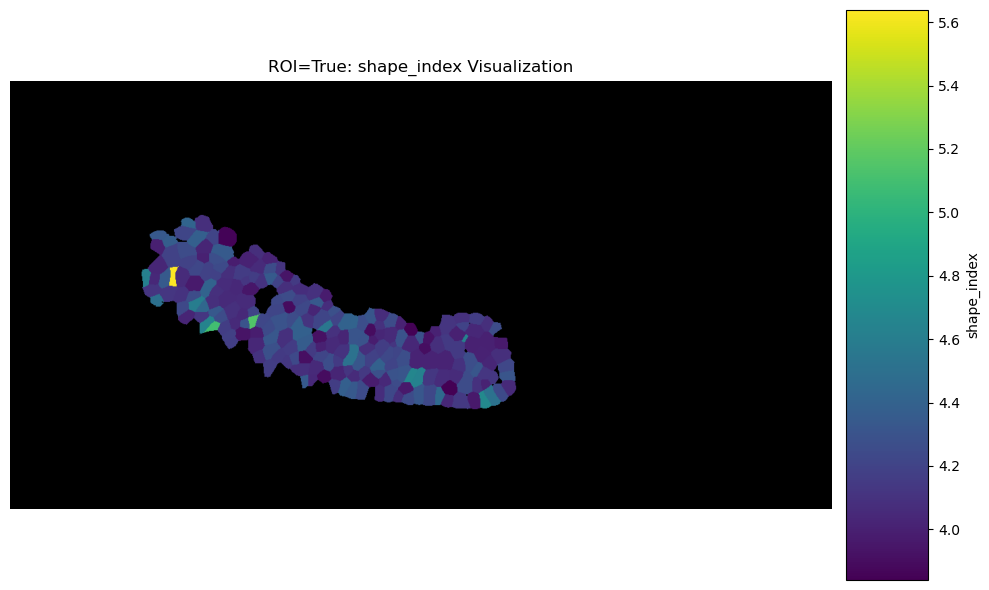

0044_cp_masks


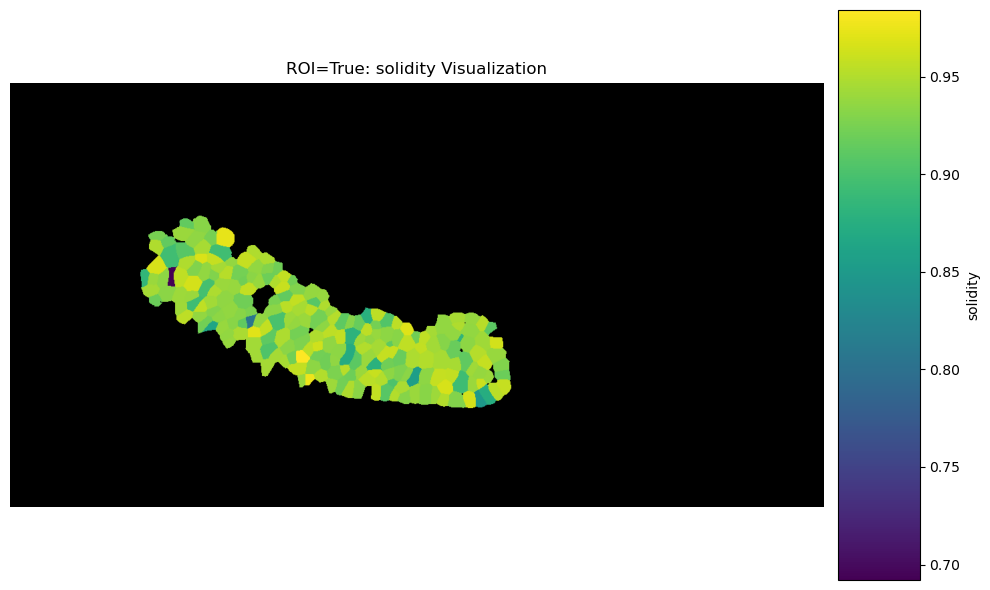

In [30]:
plot_masks_with_attribute(gullum_het_masks, attribute='shape_index', mask_image_path='H:/PROJECTS-03/Agnese/20241127_chd2xh2b_modERK_PD17/20241127_154242_Experiment/1gg/analysis/0044_cp_masks.tif', roi_filter=True)

plot_masks_with_attribute(gullum_het_masks, attribute='solidity', mask_image_path='H:/PROJECTS-03/Agnese/20241127_chd2xh2b_modERK_PD17/20241127_154242_Experiment/1gg/analysis/0044_cp_masks.tif', roi_filter=True)


### Plot Data

Text(0, 0.5, 'Number of Cells')

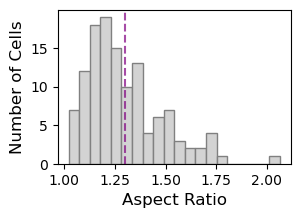

In [13]:
# HISTOGRAM

for mask_group, masks in gullum_het_masks.items():
        array = [mask["aspect_ratio"] for mask in masks.values() if mask["roi"]]  # Extract 'area' from each mask

# Create the plot
fig = plt.figure(figsize=[3, 2])
binwidth = 1
#bin_edges = np.arange(0, 20 + binwidth, binwidth)  # Use bin edges

# Plot histogram
plt.hist(array, color='lightgrey', edgecolor='grey', linewidth=1, bins=20)

# Calculate bin midpoints for xticks
#bin_midpoints = 0.5 * (bins[1:] + bins[:-1])

# Add a vertical line at the mean
plt.axvline(np.mean(array), linewidth=1.5, color='purple', alpha=0.7, linestyle='dashed')

# Adjust x and y axis ticks and limits
# plt.xticks(bin_midpoints, labels=np.arange(0, len(bin_midpoints)), fontsize=12)  # Center ticks on bars
#plt.xlim([0, 300])  # Adjust x-axis limit as needed
# plt.yticks(np.arange(0, 30, 3), fontsize=12)
#plt.ylim([0, 15])  # Adjust y-axis limit as needed

# Titles and labels
plt.xlabel('Aspect Ratio', fontsize=12)
plt.ylabel('Number of Cells', fontsize=12)


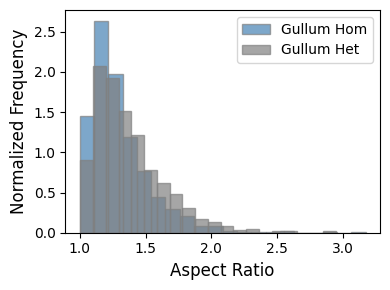

In [119]:
hom_aspect_ratios = [
    mask["aspect_ratio"]
    for masks in gullum_het_masks.values()
    for mask in masks.values()
    if mask["roi"]
]

het_aspect_ratios = [
    mask["aspect_ratio"]
    for masks in gullum_het_masks.values()
    for mask in masks.values()
    if mask["roi"]
]
# Create the histogram
plt.figure(figsize=(4, 3))


# Plot the normalized histogram for Gullum Hom with transparency
plt.hist(hom_aspect_ratios, bins=20, color='steelblue', alpha=0.7, label="Gullum Hom", density=True, edgecolor='gray')

# Plot the normalized histogram for Gullum Het with full opacity
plt.hist(het_aspect_ratios, bins=20, color='gray', alpha=0.7, label="Gullum Het", density=True, edgecolor='gray')

# Add a legend
plt.legend()

plt.xlabel("Aspect Ratio", fontsize=12)
plt.ylabel("Normalized Frequency", fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

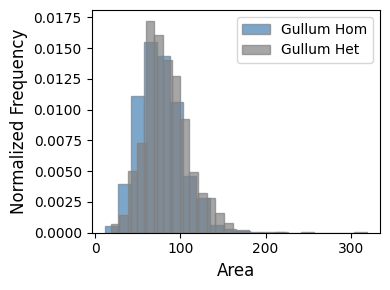

In [ ]:
hom_aspect_ratios = [
    mask["area"]
    for masks in gullum_hom_masks.values()
    for mask in masks.values()
    if mask["roi"]
]

het_aspect_ratios = [
    mask["area"]
    for masks in gullum_het_masks.values()
    for mask in masks.values()
    if mask["roi"]
]
# Create the histogram
plt.figure(figsize=(4, 3))


# Plot the normalized histogram for Gullum Hom with transparency
plt.hist(hom_aspect_ratios, bins=20, color='steelblue', alpha=0.7, label="Gullum Hom", density=True, edgecolor='gray')

# Plot the normalized histogram for Gullum Het with full opacity
plt.hist(het_aspect_ratios, bins=20, color='gray', alpha=0.7, label="Gullum Het", density=True, edgecolor='gray')

# Add a legend
plt.legend()

plt.xlabel("Area", fontsize=12)
plt.ylabel("Normalized Frequency", fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

In [121]:
from scipy.stats import shapiro, ttest_ind, mannwhitneyu

# Check normality for both groups using Shapiro-Wilk test
stat_hom, p_hom = shapiro(hom_aspect_ratios)
stat_het, p_het = shapiro(het_aspect_ratios)

print(f"Shapiro-Wilk Test (Gullum Hom): W={stat_hom:.3f}, p={p_hom:.3f}")
print(f"Shapiro-Wilk Test (Gullum Het): W={stat_het:.3f}, p={p_het:.3f}")

# Determine normality and decide which test to use
if p_hom > 0.05 and p_het > 0.05:
    print("Both datasets are normally distributed. Performing t-test.")
    # Perform independent t-test
    t_stat, t_p = ttest_ind(hom_aspect_ratios, het_aspect_ratios, equal_var=False)
    print(f"T-Test: t={t_stat:.3f}, p={t_p:.3f}")
else:
    print("At least one dataset is not normally distributed. Performing Wilcoxon rank-sum test.")
    # Perform Wilcoxon rank-sum test (Mann-Whitney U test)
    u_stat, u_p = mannwhitneyu(hom_aspect_ratios, het_aspect_ratios, alternative="two-sided")
    print(f"Mann-Whitney U Test: U={u_stat:.3f}, p={u_p:.3f}")

# Interpret p-values
if (p_hom > 0.05 and p_het > 0.05 and t_p < 0.05) or (p_hom <= 0.05 or p_het <= 0.05 and u_p < 0.05):
    print("The difference in aspect ratios between Gullum Hom and Gullum Het is statistically significant.")
else:
    print("No significant difference in aspect ratios between Gullum Hom and Gullum Het.")


Shapiro-Wilk Test (Gullum Hom): W=0.961, p=0.000
Shapiro-Wilk Test (Gullum Het): W=0.978, p=0.000
At least one dataset is not normally distributed. Performing Wilcoxon rank-sum test.
Mann-Whitney U Test: U=1712739.500, p=0.000
The difference in aspect ratios between Gullum Hom and Gullum Het is statistically significant.


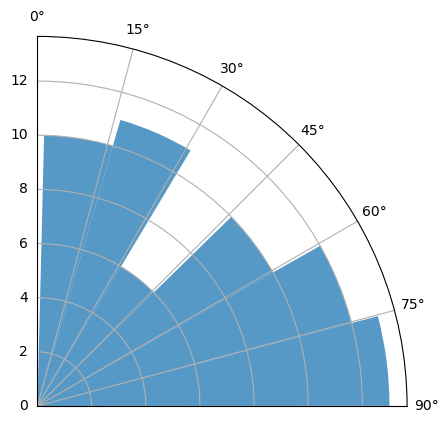

In [14]:
# POLAR HISTOGRAM

for mask_group, masks in gullum_het_masks.items():
        
        angles_degrees = [mask["orientation"] if mask["orientation"] <= 90 else 180 - mask["orientation"] for mask in masks.values() if mask["roi"] and mask["aspect_ratio"] > 1.25]

        #angles_degrees = [mask["orientation"] for mask in masks.values() if mask['orientation'] and mask["roi"] and mask["aspect_ratio"]>1.25 ] 

        #angles_degrees = [mask["orientation"] for mask in masks.values() if mask["roi"] ]  

# Convert angles to radians for plotting
angles_radians = np.radians(angles_degrees)

# Create the half-polar histogram
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.set_theta_zero_location("N")  # Set 0 degrees at the top
ax.set_theta_direction(-1)       # Set angles to increase clockwise
ax.set_thetalim(0, np.pi/2)        # Limit the angle to 0-180 degrees

# Plot the histogram
num_bins = 6  # Adjust the number of bins as needed
ax.hist(angles_radians, bins=num_bins, alpha=0.75)



# Show the plot
plt.show()


In [19]:
# Along LOI
# Iterate over the values of 'gullumhet-1_cp_masks'
angles_degrees = [
    mask["aspect_ratio"] for mask in gullum_het_masks['composite-015_cp_masks'].values() if mask["roi"]
]
loi_distances = [
    mask["loi_distance"] for mask in gullum_het_masks['composite-015_cp_masks'].values() if mask["roi"]
]


#for mask_group, masks in gullum_het_masks.items():
 #       angles_degrees = [mask["aspect_ratio"] for mask in masks.values() if mask["roi"]] 
  #      loi_distances = [mask["loi_distance"] for mask in masks.values() if mask["roi"]]

        
        #angles_degrees = [mask["orientation"]%90 for mask in masks.values() if mask["roi"] and mask["aspect_ratio"]>1.25] 
        #loi_distances = [mask["loi_distance"] for mask in masks.values() if mask["roi"] and mask["aspect_ratio"]>1.25]

plt.figure(figsize=(8, 6))
plt.plot(loi_distances, angles_degrees,  marker='o', linestyle = '')

# Add labels, title, and legend
plt.ylabel("x")
plt.xlabel("LOI Distance")
plt.title("LOI Distance vs. x")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


KeyError: 'composite-015_cp_masks'

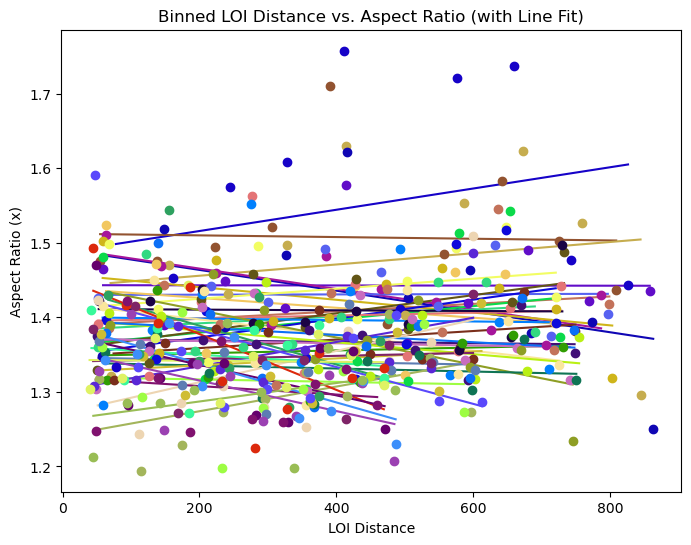

In [ ]:
# Binned Along LOI, with linear fitting

plt.figure(figsize=(8, 6))

# Iterate over each key in 'gullum_het_masks'
for mask_group, masks in gullum_het_masks.items():
    # Extract data for current mask group
    angles_degrees = [mask["aspect_ratio"] for mask in masks.values() if mask["roi"]]
    loi_distances = [mask["loi_distance"] for mask in masks.values() if mask["roi"]]

    # Define the number of bins
    num_bins = 10  # Adjust the number of bins as needed

    # Create the bins along the x-axis (LOI distance)
    bin_edges = np.linspace(min(loi_distances), max(loi_distances), num_bins + 1)

    # Digitize LOI distances to bin them
    binned_indices = np.digitize(loi_distances, bin_edges)

    # Compute average angles for each bin
    binned_averages = []
    for i in range(1, num_bins + 1):
        # Get the indices of the masks that fall into this bin
        bin_mask_indices = [index for j, index in enumerate(binned_indices) if index == i]
        # Get the corresponding angles for these masks and compute the average
        binned_angles = [angles_degrees[j] for j in range(len(angles_degrees)) if binned_indices[j] == i]
        if binned_angles:  # Check if there are any values in the bin
            binned_averages.append(np.mean(binned_angles))

    # Compute bin centers for plotting
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Fit a line to the binned data
    coefficients = np.polyfit(bin_centers, binned_averages, 1)  # Linear fit (degree=1)
    linear_fit = np.poly1d(coefficients)  # Create a linear polynomial function

    # Plot the binned data (average values per bin)
    color = np.random.rand(3,)  # Random color for each mask group
    plt.scatter(bin_centers, binned_averages, color=color, label=f'{mask_group} - Binned Average', zorder=5)

    # Plot the fitted line
    loi_fit_values = np.linspace(min(bin_centers), max(bin_centers), 100)
    angles_fit_values = linear_fit(loi_fit_values)
    plt.plot(loi_fit_values, angles_fit_values, color=color, linestyle='-', label=f'{mask_group} - Fit Line')

# Add labels, title, and legend
plt.xlabel("LOI Distance")
plt.ylabel("Aspect Ratio (x)")
plt.title("Binned LOI Distance vs. Aspect Ratio (with Line Fit)")

# Add a legend to differentiate each mask group
plt.legend()

# Show grid
plt.grid(True)

# Show the plot
plt.show()


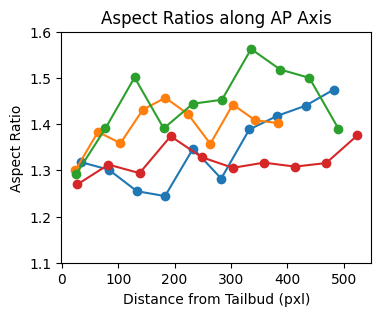

In [176]:
# Binned Along LOI

# Example: Iterate over mask groups
plt.figure(figsize=(4, 3))

# Iterate over each key in 'gullum_het_masks'
for mask_group, masks in gullum_het_masks.items():
    # Extract data for current mask group
    aspect_ratios = [mask["aspect_ratio"] for mask in masks.values() if mask["roi"]]
    loi_distances = [mask["loi_distance"] for mask in masks.values() if mask["roi"]]

    # Define the number of bins
    num_bins = 10  # Adjust the number of bins as needed

    # Create the bins along the x-axis (LOI distance)
    bin_edges = np.linspace(min(loi_distances), max(loi_distances), num_bins + 1)

    # Digitize LOI distances to bin them
    binned_indices = np.digitize(loi_distances, bin_edges)

    # Compute average angles for each bin
    binned_averages = []
    for i in range(1, num_bins + 1):
        # Get the indices of the masks that fall into this bin
        bin_mask_indices = [index for j, index in enumerate(binned_indices) if index == i]
        # Get the corresponding angles for these masks and compute the average
        binned_angles = [aspect_ratios[j] for j in range(len(aspect_ratios)) if binned_indices[j] == i]
        if binned_angles:  # Check if there are any values in the bin
            binned_averages.append(np.mean(binned_angles))

    # Compute bin centers for plotting
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])


    # Plot the binned data (average values per bin)
    plt.plot(bin_centers, binned_averages, label=f'{mask_group} - Binned Average', zorder=5, marker = 'o')


# Add labels, title, and legend
plt.xlabel("Distance from Tailbud (pxl)")
plt.ylabel("Aspect Ratio")
plt.ylim([1.1, 1.6])
plt.title("Aspect Ratios along AP Axis")

# Add a legend to differentiate each mask group
# plt.legend()



# Show the plot
plt.show()


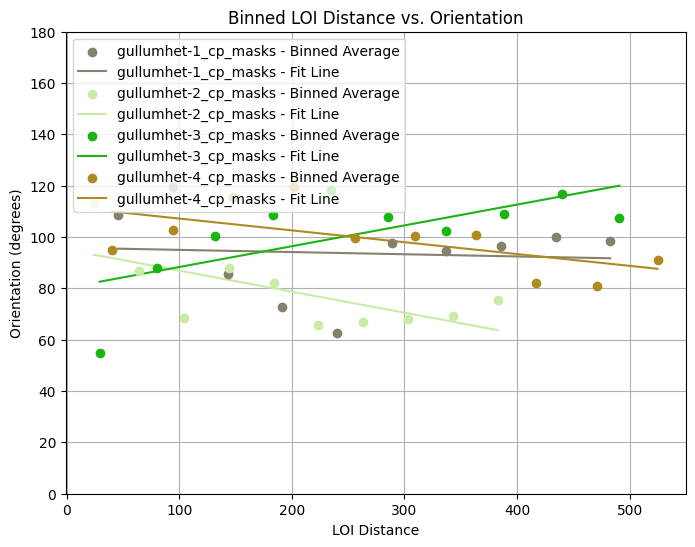

In [187]:
# Binned Along LOI, with linear fitting

plt.figure(figsize=(8, 6))

# Iterate over each key in 'gullum_het_masks'
for mask_group, masks in gullum_het_masks.items():
    # Extract data for current mask group
    angles_degrees = [mask["orientation"] for mask in masks.values() if mask['orientation'] and mask["roi"] and mask["aspect_ratio"]>1.25 ] 

    loi_distances = [mask["loi_distance"] for mask in masks.values() if mask["roi"] and mask["aspect_ratio"]>1.25 ]

    # Define the number of bins
    num_bins = 10  # Adjust the number of bins as needed

    # Create the bins along the x-axis (LOI distance)
    bin_edges = np.linspace(min(loi_distances), max(loi_distances), num_bins + 1)

    # Digitize LOI distances to bin them
    binned_indices = np.digitize(loi_distances, bin_edges)

    # Compute average angles for each bin
    binned_averages = []
    for i in range(1, num_bins + 1):
        # Get the indices of the masks that fall into this bin
        bin_mask_indices = [index for j, index in enumerate(binned_indices) if index == i]
        # Get the corresponding angles for these masks and compute the average
        binned_angles = [angles_degrees[j] for j in range(len(angles_degrees)) if binned_indices[j] == i]
        if binned_angles:  # Check if there are any values in the bin
            binned_averages.append(np.mean(binned_angles))

    # Compute bin centers for plotting
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Fit a line to the binned data
    coefficients = np.polyfit(bin_centers, binned_averages, 1)  # Linear fit (degree=1)
    linear_fit = np.poly1d(coefficients)  # Create a linear polynomial function

    # Plot the binned data (average values per bin)
    color = np.random.rand(3,)  # Random color for each mask group
    plt.scatter(bin_centers, binned_averages, color=color, label=f'{mask_group} - Binned Average', zorder=5)

    # Plot the fitted line
    loi_fit_values = np.linspace(min(bin_centers), max(bin_centers), 100)
    angles_fit_values = linear_fit(loi_fit_values)
    plt.plot(loi_fit_values, angles_fit_values, color=color, linestyle='-', label=f'{mask_group} - Fit Line')

# Add labels, title, and legend
plt.xlabel("LOI Distance")
plt.ylabel("Orientation (degrees)")
plt.title("Binned LOI Distance vs. Orientation")
plt.ylim([0,180])

# Add a legend to differentiate each mask group
plt.legend()

# Show grid
plt.grid(True)

# Show the plot
plt.show()


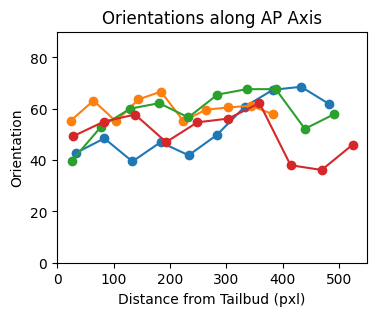

In [190]:
# Binned Along LOI

# Example: Iterate over mask groups
plt.figure(figsize=(4, 3))

for mask_group, masks in gullum_het_masks.items():
    # Extract data for current mask group
    angles_degrees = [mask["orientation"] if mask["orientation"] <= 90 else 180 - mask["orientation"] for mask in masks.values() if mask["roi"] and mask["aspect_ratio"] > 1.1]
    loi_distances = [mask["loi_distance"] for mask in masks.values() if mask["roi"] and mask["aspect_ratio"] > 1.1]

    # Define the number of bins
    num_bins = 10  # Adjust the number of bins as needed

    # Create the bins along the x-axis (LOI distance)
    bin_edges = np.linspace(min(loi_distances), max(loi_distances), num_bins + 1)

    # Digitize LOI distances to bin them
    binned_indices = np.digitize(loi_distances, bin_edges)

    # Compute average angles for each bin
    binned_averages = []
    for i in range(1, num_bins + 1):
        # Get the indices of the masks that fall into this bin
        bin_mask_indices = [index for j, index in enumerate(binned_indices) if index == i]
        # Get the corresponding angles for these masks and compute the average
        binned_angles = [angles_degrees[j] for j in range(len(angles_degrees)) if binned_indices[j] == i]
        if binned_angles:  # Check if there are any values in the bin
            binned_averages.append(np.mean(binned_angles))

    # Compute bin centers for plotting
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])


    # Plot the binned data (average values per bin)
    plt.plot(bin_centers, binned_averages, label=f'{mask_group} - Binned Average', zorder=5, marker = 'o')


# Add labels, title, and legend
plt.xlabel("Distance from Tailbud (pxl)")
plt.ylabel("Orientation")
plt.ylim([0, 90])
plt.title("Orientations along AP Axis")

# Add a legend to differentiate each mask group
# plt.legend()



# Show the plot
plt.show()


In [ ]:
plot_masks_with_attribute(fss_het_masks, attribute='aspect_ratio', mask_image_path='//sv-nas1.rcp.epfl.ch/upoates/common/Feyza/data_BIOP/241217-pmyosin-yap_gullumbg(yapgood,pmyobad,dapiokay)/dapi-midpsm-snaps\gullum-2_cp_masks.tif', roi_filter=True)

plot_masks_with_attribute(fss_het_masks, attribute='orientation', mask_image_path='//sv-nas1.rcp.epfl.ch/upoates/common/Feyza/data_BIOP/241217-pmyosin-yap_gullumbg(yapgood,pmyobad,dapiokay)/dapi-midpsm-snaps\gullum-2_cp_masks.tif', roi_filter=True)


### fss_hom vs wt/fss_het

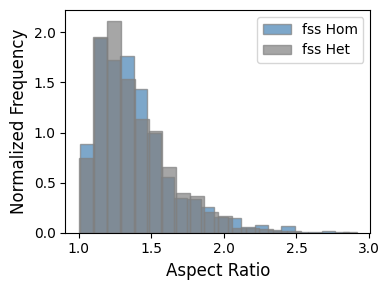

In [130]:
hom_aspect_ratios = [
    mask["aspect_ratio"]
    for masks in fss_hom_masks.values()
    for mask in masks.values()
    if mask["roi"]
]

het_aspect_ratios = [
    mask["aspect_ratio"]
    for masks in fss_het_masks.values()
    for mask in masks.values()
    if mask["roi"]
]
# Create the histogram
plt.figure(figsize=(4, 3))


# Plot the normalized histogram for Gullum Hom with transparency
plt.hist(hom_aspect_ratios, bins=20, color='steelblue', alpha=0.7, label="fss Hom", density=True, edgecolor='gray')

# Plot the normalized histogram for Gullum Het with full opacity
plt.hist(het_aspect_ratios, bins=20, color='gray', alpha=0.7, label="fss Het", density=True, edgecolor='gray')

# Add a legend
plt.legend()

plt.xlabel("Aspect Ratio", fontsize=12)
plt.ylabel("Normalized Frequency", fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

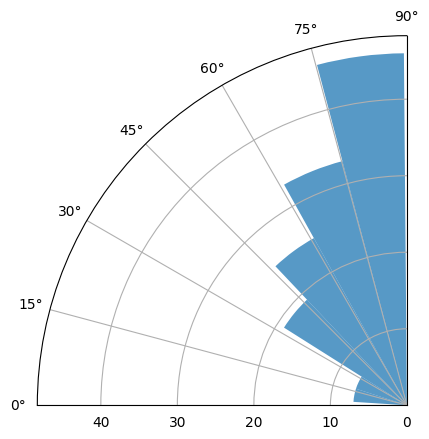

In [ ]:
# POLAR HISTOGRAM

for mask_group, masks in fss_hom_masks.items():
        
        angles_degrees = [mask["orientation"] if mask["orientation"] <= 90 else 180 - mask["orientation"] for mask in masks.values() if mask["roi"] and mask["aspect_ratio"] > 1.25]

        #angles_degrees = [mask["orientation"] for mask in masks.values() if mask['orientation'] and mask["roi"] and mask["aspect_ratio"]>1.25 ] 

        #angles_degrees = [mask["orientation"] for mask in masks.values() if mask["roi"] ]  

# Convert angles to radians for plotting
angles_radians = np.radians(angles_degrees)

# Create the half-polar histogram
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.set_theta_zero_location("W")  # Set 0 degrees at the top
ax.set_theta_direction(-1)       # Set angles to increase clockwise
ax.set_thetalim(0, np.pi/2)        # Limit the angle to 0-180 degrees

# Plot the histogram
num_bins = 6  # Adjust the number of bins as needed
ax.hist(angles_radians, bins=num_bins, alpha=0.75) 
# ax.hist(angles_radians, bins=num_bins, alpha=0.75, color='gray')


# Show the plot
plt.show()


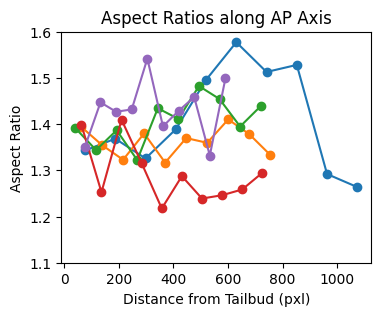

In [138]:
# Binned Along LOI

# Example: Iterate over mask groups
plt.figure(figsize=(4, 3))
for mask_group, masks in fss_het_masks.items():
    # Extract data for current mask group
    aspect_ratios = [mask["aspect_ratio"] for mask in masks.values() if mask["roi"]]
    loi_distances = [mask["loi_distance"] for mask in masks.values() if mask["roi"]]

    # Define the number of bins
    num_bins = 10  # Adjust the number of bins as needed

    # Create the bins along the x-axis (LOI distance)
    bin_edges = np.linspace(min(loi_distances), max(loi_distances), num_bins + 1)

    # Digitize LOI distances to bin them
    binned_indices = np.digitize(loi_distances, bin_edges)

    # Compute average angles for each bin
    binned_averages = []
    for i in range(1, num_bins + 1):
        # Get the indices of the masks that fall into this bin
        bin_mask_indices = [index for j, index in enumerate(binned_indices) if index == i]
        # Get the corresponding angles for these masks and compute the average
        binned_angles = [aspect_ratios[j] for j in range(len(aspect_ratios)) if binned_indices[j] == i]
        if binned_angles:  # Check if there are any values in the bin
            binned_averages.append(np.mean(binned_angles))

    # Compute bin centers for plotting
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])


    # Plot the binned data (average values per bin)
    plt.plot(bin_centers, binned_averages, label=f'{mask_group} - Binned Average', zorder=5, marker = 'o')


# Add labels, title, and legend
plt.xlabel("Distance from Tailbud (pxl)")
plt.ylabel("Aspect Ratio")
plt.ylim([1.1, 1.6])
plt.title("Aspect Ratios along AP Axis")

# Add a legend to differentiate each mask group
# plt.legend()



# Show the plot
plt.show()


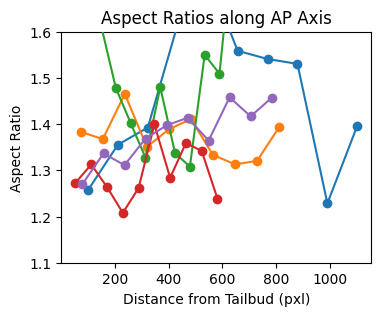

In [139]:
# Binned Along LOI

# Example: Iterate over mask groups
plt.figure(figsize=(4, 3))
for mask_group, masks in fss_hom_masks.items():
    # Extract data for current mask group
    aspect_ratios = [mask["aspect_ratio"] for mask in masks.values() if mask["roi"]]
    loi_distances = [mask["loi_distance"] for mask in masks.values() if mask["roi"]]

    # Define the number of bins
    num_bins = 10  # Adjust the number of bins as needed

    # Create the bins along the x-axis (LOI distance)
    bin_edges = np.linspace(min(loi_distances), max(loi_distances), num_bins + 1)

    # Digitize LOI distances to bin them
    binned_indices = np.digitize(loi_distances, bin_edges)

    # Compute average angles for each bin
    binned_averages = []
    for i in range(1, num_bins + 1):
        # Get the indices of the masks that fall into this bin
        bin_mask_indices = [index for j, index in enumerate(binned_indices) if index == i]
        # Get the corresponding angles for these masks and compute the average
        binned_angles = [aspect_ratios[j] for j in range(len(aspect_ratios)) if binned_indices[j] == i]
        if binned_angles:  # Check if there are any values in the bin
            binned_averages.append(np.mean(binned_angles))

    # Compute bin centers for plotting
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])


    # Plot the binned data (average values per bin)
    plt.plot(bin_centers, binned_averages, label=f'{mask_group} - Binned Average', zorder=5, marker = 'o')


# Add labels, title, and legend
plt.xlabel("Distance from Tailbud (pxl)")
plt.ylabel("Aspect Ratio")
plt.ylim([1.1, 1.6])
plt.title("Aspect Ratios along AP Axis")

# Add a legend to differentiate each mask group
# plt.legend()



# Show the plot
plt.show()


### membrane mask plotting